In [2]:
from collections import defaultdict, namedtuple
import sys
import json
import numpy as np
from itertools import combinations
import scipy.stats as stats
import matplotlib.pyplot as plt

In [18]:
phase_dir = '../phased_ihart'
deletion_dir = '../deletions_ihart_asym'
ped_file = '../data/v34.vcf.ped'
identicals_file = '../sibpair_similarity/identicals.txt'

family_sizes = [3, 4, 5, 6]
chroms = [str(x) for x in range(1, 23)]

In [19]:
# pull cytobands
intervals = []

with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2])))
intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))

interval_chroms = np.array([int(x[0]) for x in intervals])
first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()


In [20]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		if len(pieces) >= 6:
			fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
			child_id_to_affected[child_id] = disease_status
			child_id_to_sex[child_id] = sex
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 4611


In [21]:
# pull families
family_to_individuals = dict()
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, '1', j), 'r') as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            individuals = pieces[1:(1+j)]
            family_to_individuals[family_key] = individuals

In [34]:
# mat/pat/all unaffected-inherits-more_dels/affected-inherits-more-dels
sibpair_num_dels = np.zeros((len(intervals), 3, 2), dtype=int)
sibpair_bp_dels = np.zeros((len(intervals), 3, 2), dtype=int)

def del_to_key(deletion):
    return (deletion['family'], deletion['chrom'], deletion['start_pos'], deletion['end_pos'], deletion['is_mat'], tuple(sorted(deletion['trans'])))

for chrom in chroms:
    with open('%s/chr.%s.collections.json' % (deletion_dir, chrom), 'r') as f:
        collections = json.load(f)
    print('collections', len(collections))
        
    rare_deletions = dict()
    for collection in collections:
        if len(collection['matches']) <= 5:#0.01*len(family_to_individuals)*4:
            for deletion in collection['matches']:
                rare_deletions[del_to_key(deletion)] = deletion
    rare_deletions = list(rare_deletions.values())
    print('rare_deletions', len(rare_deletions))
    
    #with open('%s/chr.%s.deletions.json' % (deletion_dir, chrom), 'r') as f:
    #    rare_deletions = json.load(f)
        
    for i, (ch, cyto, chrom_start_pos, chrom_end_pos) in enumerate(intervals):
        if ch == chrom:
            child_to_num_mat_deletions = defaultdict(int)
            child_to_num_pat_deletions = defaultdict(int)
            child_to_bp_mat_deletions = defaultdict(int)
            child_to_bp_pat_deletions = defaultdict(int)

            for deletion in rare_deletions:
                start_pos, end_pos = deletion['start_pos'], deletion['end_pos']
                
                if ((start_pos >= chrom_start_pos) and (start_pos <= chrom_end_pos)) or ((end_pos >= chrom_start_pos) & (end_pos <= chrom_end_pos)): 
                    for child in deletion['trans']:
                        if deletion['is_mat']:
                            child_to_num_mat_deletions[child] += 1
                            child_to_bp_mat_deletions[child] += min(chrom_end_pos, end_pos) - max(chrom_start_pos, start_pos) + 1
                        if deletion['is_pat']:
                            child_to_num_pat_deletions[child] += 1
                            child_to_bp_pat_deletions[child] += min(chrom_end_pos, end_pos) - max(chrom_start_pos, start_pos) + 1

            for famkey, inds in family_to_individuals.items():
                for child1, child2 in combinations(inds[2:], 2):
                    affected_child, unaffected_child = None, None
                    if child_id_to_affected[child1] == '2' and child_id_to_affected[child2] == '1':
                        affected_child = child1
                        unaffected_child = child2
                    elif child_id_to_affected[child1] == '1' and child_id_to_affected[child2] == '2':
                        affected_child = child2
                        unaffected_child = child1

                    if affected_child is not None and unaffected_child is not None:
                        if child_to_num_mat_deletions[affected_child] > child_to_num_mat_deletions[unaffected_child]:
                            sibpair_num_dels[i, 0, 1] += 1
                        elif child_to_num_mat_deletions[unaffected_child] > child_to_num_mat_deletions[affected_child]:
                            sibpair_num_dels[i, 0, 0] += 1
                        if child_to_num_pat_deletions[affected_child] > child_to_num_pat_deletions[unaffected_child]:
                            sibpair_num_dels[i, 1, 1] += 1
                        elif child_to_num_pat_deletions[unaffected_child] > child_to_num_pat_deletions[affected_child]:
                            sibpair_num_dels[i, 1, 0] += 1
                        if child_to_num_mat_deletions[affected_child]+child_to_num_pat_deletions[affected_child] > child_to_num_mat_deletions[unaffected_child]+child_to_num_pat_deletions[unaffected_child]:
                            sibpair_num_dels[i, 2, 1] += 1
                        elif child_to_num_mat_deletions[unaffected_child]+child_to_num_pat_deletions[unaffected_child] > child_to_num_mat_deletions[affected_child]+child_to_num_pat_deletions[affected_child]:
                            sibpair_num_dels[i, 2, 0] += 1

                        if child_to_bp_mat_deletions[affected_child] > child_to_bp_mat_deletions[unaffected_child]:
                            sibpair_bp_dels[i, 0, 1] += 1
                        elif child_to_bp_mat_deletions[unaffected_child] > child_to_bp_mat_deletions[affected_child]:
                            sibpair_bp_dels[i, 0, 0] += 1
                        if child_to_bp_pat_deletions[affected_child] > child_to_bp_pat_deletions[unaffected_child]:
                            sibpair_bp_dels[i, 1, 1] += 1
                        elif child_to_bp_pat_deletions[unaffected_child] > child_to_bp_pat_deletions[affected_child]:
                            sibpair_bp_dels[i, 1, 0] += 1
                        if child_to_bp_mat_deletions[affected_child]+child_to_bp_pat_deletions[affected_child] > child_to_bp_mat_deletions[unaffected_child]+child_to_bp_pat_deletions[unaffected_child]:
                            sibpair_bp_dels[i, 2, 1] += 1
                        elif child_to_bp_mat_deletions[unaffected_child]+child_to_bp_pat_deletions[unaffected_child] > child_to_bp_mat_deletions[affected_child]+child_to_bp_pat_deletions[affected_child]:
                            sibpair_bp_dels[i, 2, 0] += 1


collections 10987
rare_deletions 5135
collections 11615
rare_deletions 4949
collections 7174
rare_deletions 4038
collections 9612
rare_deletions 4562
collections 7493
rare_deletions 3913
collections 7798
rare_deletions 3822
collections 9247
rare_deletions 4477
collections 8216
rare_deletions 3872
collections 8905
rare_deletions 3541
collections 6366
rare_deletions 3071
collections 7002
rare_deletions 3188
collections 5247
rare_deletions 2992
collections 4227
rare_deletions 2113
collections 11188
rare_deletions 2563
collections 5430
rare_deletions 2608
collections 4733
rare_deletions 2731
collections 4470
rare_deletions 2228
collections 3238
rare_deletions 1754
collections 5649
rare_deletions 2255
collections 2341
rare_deletions 1308
collections 1993
rare_deletions 1082
collections 3508
rare_deletions 1457


In [35]:
num_pvalues = np.ones((len(intervals), 3))
bp_pvalues = np.ones((len(intervals), 3))
for i in range(len(intervals)):
    num_pvalues[i, 0] = stats.binom_test(sibpair_num_dels[i, 0, :])
    num_pvalues[i, 1] = stats.binom_test(sibpair_num_dels[i, 1, :])
    num_pvalues[i, 2] = stats.binom_test(sibpair_num_dels[i, 2, :])
    
    bp_pvalues[i, 0] = stats.binom_test(sibpair_bp_dels[i, 0, :])
    bp_pvalues[i, 1] = stats.binom_test(sibpair_bp_dels[i, 1, :])
    bp_pvalues[i, 2] = stats.binom_test(sibpair_bp_dels[i, 2, :])


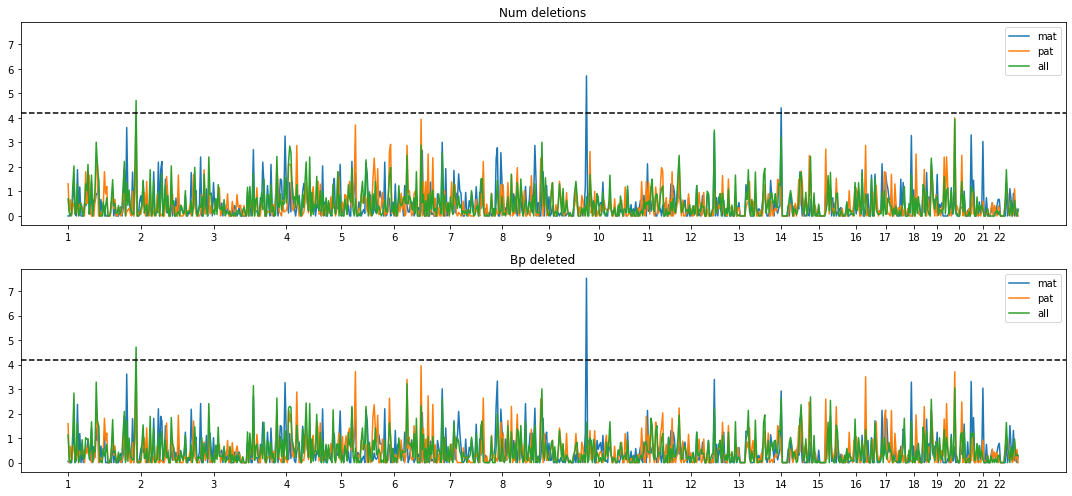

In [36]:
plt.figure(figsize=(15, 7))

cutoff = 0.05/np.sum(np.sum(sibpair_num_dels, axis=(1, 2))>0)

ax = plt.subplot(2, 1, 1)
plt.plot(-np.log10(num_pvalues[:, 0]), label='mat')
plt.plot(-np.log10(num_pvalues[:, 1]), label='pat')
plt.plot(-np.log10(num_pvalues[:, 2]), label='all')
plt.legend()
plt.title('Num deletions')
plt.xticks(first_chrom, chroms)
plt.axhline(-np.log10(cutoff), color='black', linestyle='--')

plt.subplot(2, 1, 2, sharey=ax)
plt.plot(-np.log10(bp_pvalues[:, 0]), label='mat')
plt.plot(-np.log10(bp_pvalues[:, 1]), label='pat')
plt.plot(-np.log10(bp_pvalues[:, 2]), label='all')
plt.legend()
plt.title('Bp deleted')
plt.xticks(first_chrom, chroms)
plt.axhline(-np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [39]:
print([intervals[i] for i in np.where(np.any(-np.log10(num_pvalues)>-np.log10(cutoff), axis=1))[0]])
print([intervals[i] for i in np.where(np.any(-np.log10(bp_pvalues)>-np.log10(cutoff), axis=1))[0]])

[('1', 'q42.13', 225100000, 228800000), ('9', 'q31.1', 101600000, 107200000), ('13', 'q34', 109100000, 114142980)]
[('1', 'q42.13', 225100000, 228800000), ('9', 'q31.1', 101600000, 107200000)]


In [29]:
print([intervals[i] for i in np.where(-np.log10(num_pvalues[:, 2])>-np.log10(cutoff))[0]])
print([intervals[i] for i in np.where(-np.log10(bp_pvalues[:, 2])>-np.log10(cutoff))[0]])

[('2', 'p16.3', 47600000, 52700000)]
[]


In [25]:
print([intervals[i] for i in np.where(-np.log10(num_pvalues[:, 2])>-np.log10(cutoff))[0]])
print([intervals[i] for i in np.where(-np.log10(bp_pvalues[:, 2])>-np.log10(cutoff))[0]])

[('2', 'p16.3', 47600000, 52700000), ('9', 'q31.1', 101600000, 107200000)]
[]
